In this file ,
We used a vanilla LightGBM model to reduce features from 1,500 to ~300, retaining 95% of the data's variance. 
LightGBM's speed, scalability, and ability to handle encoded categorical features made it ideal for high-dimensional
healthcare data. Feature importance analysis identified the top contributors to the target variable,
with the top 20 features visualized and validated against domain knowledge to ensure relevance.

This File contains the following models
1. Logistic Regression
2. Random Forest
3. Random Forest with Hyperparameter tuning
4. Hyperparameter tuning with with Optuna
5. The XGBoost model with the outputs of Optuna

Our next file contains the Training , evaluation and explainablity of LightGBM and XGBoost {8_light_xg}

In [23]:
import pandas as pd
df = pd.read_csv("encoded_data_final_tf_idftarget1.csv")

In [24]:
df.shape

(257576, 1317)

In [25]:
df

Unnamed: 0   NCT Number  Study Status  Study Results  Conditions  \
0                0  NCT00559130             1              0    0.787961   
1                1  NCT00937664             0              0    0.871238   
2                2  NCT00441597             1              0    0.902222   
3                3  NCT03296228             1              0    0.826087   
4                4  NCT00421603             1              1    0.858974   
...            ...          ...           ...            ...         ...   
257571      257571  NCT02360800             1              0    0.900000   
257572      257572  NCT02352506             1              0    0.849711   
257573      257573  NCT04996381             1              0    1.000000   
257574      257574  NCT00380640             1              0    0.714286   
257575      257575  NCT01844336             1              0    1.000000   

        Interventions  Sex  Phases  Enrollment  Funder Type  ...  \
0            1.000000    0       7    4.615121            3  ...   
1            0.427615    0       1    3.218876            3  ...   
2            0.916667    2       6    3.433987            6  ...   
3            0.855230    0       7    4.905275            6  ...   
4            0.827615    0       3    4.406719            6  ...   
...               ...  ...     ...         ...          ...  ...   
257571       0.855230    0       7    4.795791            6  ...   
257572       1.000000    0       7    5.872118            6  ...   
257573       1.000000    0       7    5.872118            6  ...   
257574       0.855230    0       3    2.397895            6  ...   
257575       0.855230    0       7    5.342334            3  ...   

        TFIDF_title_training  TFIDF_title_transplant  \
0                        0.0                     0.0   
1                        0.0                     0.0   
2                        0.0                     0.0   
3                        0.0                     0.0   
4                        0.0                     0.0   
...                      ...                     ...   
257571                   0.0                     0.0   
257572                   0.0                     0.0   
257573                   0.0                     0.0   
257574                   0.0                     0.0   
257575                   0.0                     0.0   

        TFIDF_title_transplantation  TFIDF_title_treating  \
0                               0.0                   0.0   
1                               0.0                   0.0   
2                               0.0                   0.0   
3                               0.0                   0.0   
4                               0.0                   0.0   
...                             ...                   ...   
257571                          0.0                   0.0   
257572                          0.0                   0.0   
257573                          0.0                   0.0   
257574                          0.0                   0.0   
257575                          0.0                   0.0   

        TFIDF_title_treatment  TFIDF_title_tumor  TFIDF_title_unresectable  \
0                     0.00000                0.0                       0.0   
1                     0.00000                0.0                       0.0   
2                     0.00000                0.0                       0.0   
3                     0.00000                0.0                       0.0   
4                     0.21834                0.0                       0.0   
...                       ...                ...                       ...   
257571                0.00000                0.0                       0.0   
257572                0.00000                0.0                       0.0   
257573                0.00000                0.0                       0.0   
257574                0.00000                0.0                       0.0   
257575        

Data Spliting

In [26]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

df.drop(columns=["Unnamed: 0","population","NCT Number"], inplace=True, errors="ignore")

label_encoder = LabelEncoder()
df['Study Status'] = label_encoder.fit_transform(df['Study Status'])  # Converts COMPLETED (1), NON COMPLETED (0)

X = df.drop(columns=['Study Status'])
y = df['Study Status']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n✅ Data Split Done: X_train: {X_train.shape}, X_val: {X_val.shape}")



✅ Data Split Done: X_train: (206060, 1314), X_val: (51516, 1314)


In [27]:
X_train.columns = X_train.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
X_val.columns = X_val.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)

In [28]:
print(f"Number of unique columns: {len(set(X_train.columns))}")
print(f"Total columns in X_train: {X_train.shape[1]}")
print("\nDuplicate Columns:")
print(X_train.columns[X_train.columns.duplicated()])


Number of unique columns: 1314
Total columns in X_train: 1314

Duplicate Columns:
Index([], dtype='object')


Training Vanilla LightGBM

In [ ]:
lgb_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.05, random_state=42)
lgb_model.fit(X_train, y_train)

feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgb_model.feature_importances_
}).sort_values(by="importance", ascending=False)

print("\n🎯 Top 20 Important Features (LightGBM):")
print(feature_importance_df.head(20))

[LightGBM] [Info] Number of positive: 176993, number of negative: 29067
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.639789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 241557
[LightGBM] [Info] Number of data points in the train set: 206060, number of used features: 1308
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.858939 -> initscore=1.806507
[LightGBM] [Info] Start training from score 1.806507

🎯 Top 20 Important Features (LightGBM):
                                        feature  importance
1                                    Conditions         385
5                                    Enrollment         379
2                                 Interventions         372
4                                        Phases         124
270                                    duration         117
278   Study_Design_Intervention_Model

Selecting Features Contributing to 95% Importance

In [30]:
feature_importance_df["cumulative_importance"] = (
    feature_importance_df["importance"].cumsum() / feature_importance_df["importance"].sum()
)

selected_features = feature_importance_df[feature_importance_df["cumulative_importance"] <= 0.95]["feature"].tolist()

X_train_reduced = X_train[selected_features]
X_val_reduced = X_val[selected_features]

print(f"\n✔ Selected {len(selected_features)} features contributing to 95% importance.")


✔ Selected 195 features contributing to 95% importance.


In [66]:
file_path = "selected_important_features_target.xlsx"
feature_importance_df[feature_importance_df["cumulative_importance"] <= 0.95][["feature", "importance", "cumulative_importance"]].to_excel(file_path, index=False)

In [31]:
# Drop unwanted features directly from X_train_reduced and X_val_reduced
features_to_drop = [
    "TFIDF_secondaryoutcomes_due","TFIDF_primaryoutcomes_higher","TFIDF_secondaryoutcomes_life","TFIDF_criteria_allowed"
    "TFIDF_criteria_mass","TFIDF_criteria_study", "TFIDF_criteria_within", "TFIDF_criteria_patient",
    "TFIDF_summary_patient", "TFIDF_summary_treatment", "TFIDF_criteria_must",
    "TFIDF_secondaryoutcomes_day", "TFIDF_secondaryoutcomes_time",
    "TF_IDF_secondaryoutcomes_patient", "TF_IDF_criteria_week",
    "TF_IDF_criteria_active", "TF_IDF_criteria_following", "TF_IDF_criteria_time",
    "TFIDF_criteria_participate", "TFIDF_criteria_defined", "TFIDF_title_treatment",
    "TF_IDF_criteria_may", "TFIDF_primaryoutcomes_scale", "TFIDF_primaryoutcomes_patient",
    "TFIDF_secondaryoutcomes_study", "TFIDF_primaryoutcomes_number",
    "TFIDF_primaryoutcomes_defined", "TFIDF_secondaryoutcomes_scale",
    "TFIDF_secondaryoutcomes_event", "TF_IDF_criteria_enrollment",
    "TFIDF_criteria_criterion", "TFIDF_criteria_inclusion", "TFIDF_criteria_known",
    "TFIDF_criteria_prior", "TFIDF_criteria_authorized", "TFIDF_criteria_day",
    "TFIDF_criteria_randomization", "TFIDF_criteria_problem", "TFIDF_criteria_failure",
    "TFIDF_criteria_evidence", "TFIDF_criteria_concurrent", "TFIDF_criteria_risk",
    "TFIDF_criteria_agent", "TFIDF_criteria_treatment", "TFIDF_criteria_measurable",
    "TFIDF_criteria_equal", "TFIDF_criteria_including", "TFIDF_criteria_interval",
    "TFIDF_criteria_subject", "TFIDF_criteria_status", "TFIDF_criteria_requiring",
    "TFIDF_criteria_opinion", "TFIDF_criteria_basal",
    "TFIDF_secondaryoutcomes_unknownmeasures", "TFIDF_secondaryoutcomes_length",
    "TFIDF_secondaryoutcomes_endpoint", "TFIDF_secondaryoutcomes_proportion",
    "TFIDF_secondaryoutcomes_hazard", "TFIDF_secondaryoutcomes_objective",
    "TFIDF_secondaryoutcomes_response", "TFIDF_secondaryoutcomes_defined",
    "TFIDF_primaryoutcomes_rate", "TFIDF_primaryoutcomes_year",
    "TFIDF_primaryoutcomes_phase", "TFIDF_primaryoutcomes_progression",
    "TFIDF_primaryoutcomes_safety", "TFIDF_primaryoutcomes_enrolled",
    "TFIDF_primaryoutcomes_efficacy", "TFIDF_primaryoutcomes_primary",
    "TFIDF_primaryoutcomes_clinical", "TFIDF_primaryoutcomes_combination",
    "TFIDF_primaryoutcomes_cmax", "TFIDF_primaryoutcomes_cause",
    "TFIDF_primaryoutcomes_area", "TFIDF_primaryoutcomes_curve",
    "TFIDF_primaryoutcomes_objective", "TFIDF_primaryoutcomes_visual",
    "TFIDF_primaryoutcomes_criterion", "TFIDF_primaryoutcomes_unknownprimarymeasures",
    "TFIDF_primaryoutcomes_intervention", "TFIDF_primaryoutcomes_absorption",
    "TFIDF_primaryoutcomes_improvement", "TFIDF_summary_standard",
    "TFIDF_summary_intervention", "TFIDF_summary_multicenter", "TFIDF_summary_program",
    "TFIDF_summary_aimed", "TFIDF_summary_safe", "TFIDF_summary_volunteer",
    "TFIDF_summary_exercise", "TFIDF_summary_spread", "TFIDF_summary_may",
    "TFIDF_summary_help", "TFIDF_summary_drug", "TFIDF_summary_cell",
    "TFIDF_summary_stage", "TFIDF_summary_progression", "TFIDF_summary_determine",
    "TFIDF_title_registry", "TFIDF_title_effect", "TFIDF_title_patient",
    "TFIDF_title_solid", "TFIDF_title_intervention", "TFIDF_title_negative",
    "TFIDF_title_healthy", "TFIDF_secondaryoutcomes_patient", "TFIDF_criteria_active",
    "TFIDF_criteria_following", "TFIDF_criteria_may", "TFIDF_criteria_week",
    "TFIDF_criteria_greater", "TFIDF_criteria_time", "TFIDF_criteria_defined"
]

# Drop the selected features directly from the datasets
X_train_reduced.drop(columns=[col for col in features_to_drop if col in X_train_reduced.columns], inplace=True)
X_val_reduced.drop(columns=[col for col in features_to_drop if col in X_val_reduced.columns], inplace=True)

# Now, X_train_reduced and X_val_reduced will have the dropped features


C:\Users\yuvik\AppData\Local\Temp\ipykernel_13504\2381045605.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_reduced.drop(columns=[col for col in features_to_drop if col in X_train_reduced.columns], inplace=True)
C:\Users\yuvik\AppData\Local\Temp\ipykernel_13504\2381045605.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_reduced.drop(columns=[col for col in features_to_drop if col in X_val_reduced.columns], inplace=True)


In [12]:
!pip install numpy==1.23

   ---------------------------------------- 14.7/14.7 MB 108.7 kB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6


  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.23.0 which is incompatible.
tensorflow-intel 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.0 which is incompatible.
xarray 2024.7.0 requires pandas>=2.0, but you have pandas 1.5.3 which is incompatible.

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Training and Evaluating LogisticRegression

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve
)


In [ ]:
import numpy as np

X_train_reduced.replace([np.inf, -np.inf], np.nan, inplace=True)
X_val_reduced.replace([np.inf, -np.inf], np.nan, inplace=True)

X_train_reduced.fillna(X_train_reduced.mean(), inplace=True)
X_val_reduced.fillna(X_val_reduced.mean(), inplace=True)

print("✔ Replaced Inf values and handled missing data.")


C:\Users\yuvik\AppData\Local\Temp\ipykernel_13504\458484960.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_reduced.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\yuvik\AppData\Local\Temp\ipykernel_13504\458484960.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_reduced.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\yuvik\AppData\Local\Temp\ipykernel_13504\458484960.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

✔ Replaced Inf values and handled missing data.


C:\Users\yuvik\AppData\Local\Temp\ipykernel_13504\458484960.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_reduced.fillna(X_val_reduced.mean(), inplace=True)


In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_reduced = pd.DataFrame(scaler.fit_transform(X_train_reduced), columns=X_train_reduced.columns)
X_val_reduced = pd.DataFrame(scaler.transform(X_val_reduced), columns=X_val_reduced.columns)

print("✔ Applied Standard Scaling to Features.")


✔ Applied Standard Scaling to Features.


Class Weights

In [35]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("\n✔ Computed Class Weights:", class_weight_dict)



✔ Computed Class Weights: {0: 3.5445694430109747, 1: 0.5821134169147932}


In [36]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    max_iter=500, 
    solver='liblinear', 
    class_weight=class_weight_dict,  
    random_state=42
)
log_reg.fit(X_train_reduced, y_train)

y_pred = log_reg.predict(X_val_reduced)
y_pred_proba = log_reg.predict_proba(X_val_reduced)[:, 1]  

print("✔ Logistic Regression Trained Successfully with Class Weights!")


✔ Logistic Regression Trained Successfully with Class Weights!


Evaluation and Visualization

In [37]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve
)

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

roc_auc = roc_auc_score(y_val, y_pred_proba)

print("\n Classification Report:")
print(classification_report(y_val, y_pred))

print("\n Model Performance Metrics:")
print(f"🔹 Accuracy: {accuracy:.4f}")
print(f"🔹 Precision: {precision:.4f}")
print(f"🔹 Recall: {recall:.4f}")
print(f"🔹 F1 Score: {f1:.4f}")
print(f"🔹 AUC-ROC: {roc_auc:.4f}")


 Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.83      0.69      7267
           1       0.97      0.90      0.94     44249

    accuracy                           0.89     51516
   macro avg       0.78      0.87      0.81     51516
weighted avg       0.92      0.89      0.90     51516


 Model Performance Metrics:
🔹 Accuracy: 0.8924
🔹 Precision: 0.9705
🔹 Recall: 0.9021
🔹 F1 Score: 0.9351
🔹 AUC-ROC: 0.9404


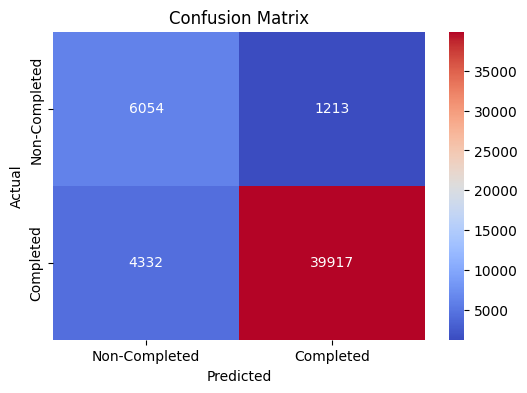

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Non-Completed", "Completed"], yticklabels=["Non-Completed", "Completed"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


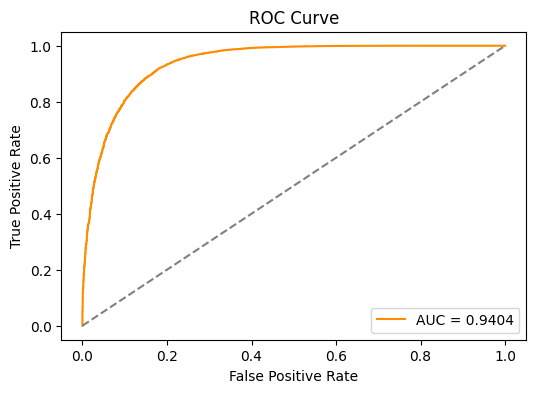

In [17]:
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", color="darkorange")
plt.plot([0,1], [0,1], linestyle="--", color="gray")  # Random Model Baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [43]:
pip install lime


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


We used LIME to generate interpretable, instance-level explanations for model predictions, ensuring transparency and alignment with domain knowledge in our healthcare-focused project.

In [47]:
import lime
import lime.lime_tabular
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [48]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_reduced.values,  
    mode="classification",  
    feature_names=X_train_reduced.columns,  
    class_names=["NON COMPLETED", "COMPLETED"],  
    discretize_continuous=True  
)


c:\Users\yuvik\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


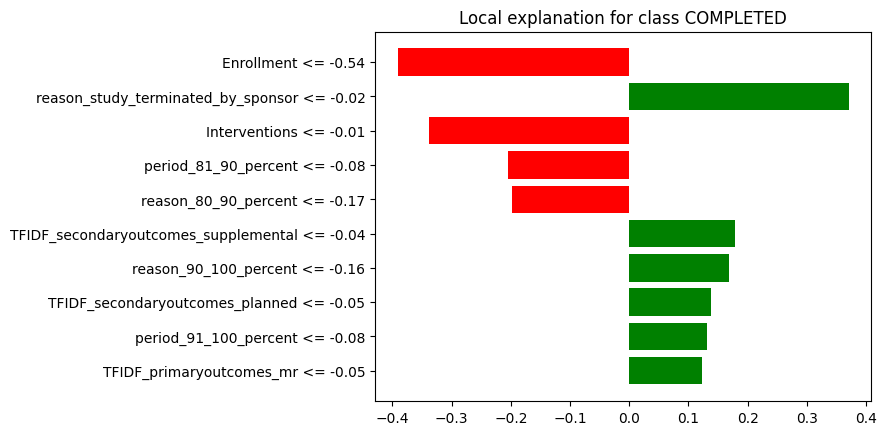

In [49]:
random_index = np.random.randint(0, X_val_reduced.shape[0])
sample_instance = X_val_reduced.iloc[random_index]

lime_exp = lime_explainer.explain_instance(
    data_row=sample_instance.values,
    predict_fn=log_reg.predict_proba
)

lime_exp.show_in_notebook()
lime_exp.as_pyplot_figure()
plt.show()


SHAP

In [ ]:
import shap

explainer = shap.KernelExplainer(log_reg.predict_proba, X_train_reduced)

shap_values = explainer.shap_values(X_val_reduced)

shap.summary_plot(shap_values[1], X_val_reduced, feature_names=X_val_reduced.columns)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_val_reduced.iloc[0], feature_names=X_val_reduced.columns)


Random Forest

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve
)
import seaborn as sns
import matplotlib.pyplot as plt

rf_baseline = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced", n_jobs=-1)
rf_baseline.fit(X_train_reduced, y_train)

y_pred_rf = rf_baseline.predict(X_val_reduced)
y_pred_proba_rf = rf_baseline.predict_proba(X_val_reduced)[:, 1]  # Probability for class 1

print("✔ Random Forest Model Trained Successfully!")


✔ Random Forest Model Trained Successfully!


Evaluation and Visualization

In [61]:
accuracy_rf = accuracy_score(y_val, y_pred_rf)
precision_rf = precision_score(y_val, y_pred_rf)
recall_rf = recall_score(y_val, y_pred_rf)
f1_rf = f1_score(y_val, y_pred_rf)
roc_auc_rf = roc_auc_score(y_val, y_pred_proba_rf)

print("\n Classification Report (Random Forest):")
print(classification_report(y_val, y_pred_rf))

print("\n Random Forest Performance Metrics:")
print(f"🔹 Accuracy: {accuracy_rf:.4f}")
print(f"🔹 Precision: {precision_rf:.4f}")
print(f"🔹 Recall: {recall_rf:.4f}")
print(f"🔹 F1 Score: {f1_rf:.4f}")
print(f"🔹 AUC-ROC: {roc_auc_rf:.4f}")



 Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.94      0.50      0.66      7267
           1       0.92      1.00      0.96     44249

    accuracy                           0.93     51516
   macro avg       0.93      0.75      0.81     51516
weighted avg       0.93      0.93      0.92     51516


 Random Forest Performance Metrics:
🔹 Accuracy: 0.9256
🔹 Precision: 0.9241
🔹 Recall: 0.9951
🔹 F1 Score: 0.9583
🔹 AUC-ROC: 0.9427


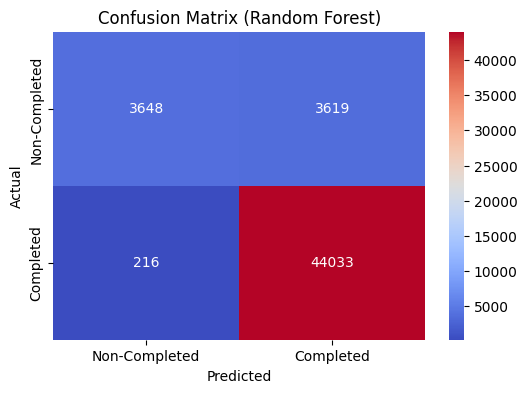

In [62]:
conf_matrix_rf = confusion_matrix(y_val, y_pred_rf)

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Non-Completed", "Completed"], yticklabels=["Non-Completed", "Completed"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Random Forest)")
plt.show()


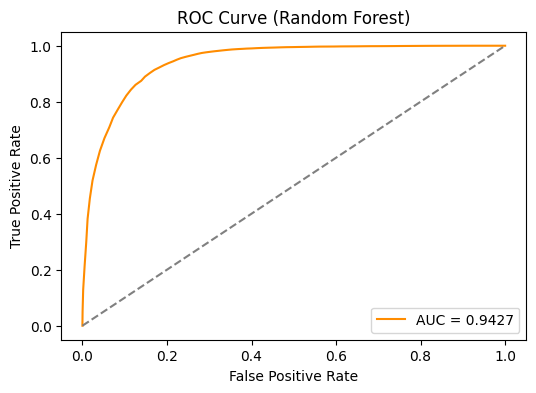

In [63]:
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_pred_proba_rf)

plt.figure(figsize=(6,4))
plt.plot(fpr_rf, tpr_rf, label=f"AUC = {roc_auc_rf:.4f}", color="darkorange")
plt.plot([0,1], [0,1], linestyle="--", color="gray")  # Random Model Baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Random Forest)")
plt.legend()
plt.show()


Feature Importance Visualization

C:\Users\yuvik\AppData\Local\Temp\ipykernel_12020\4255233014.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_rf['importance'][:20], y=feature_importance_rf['feature'][:20], palette="coolwarm")


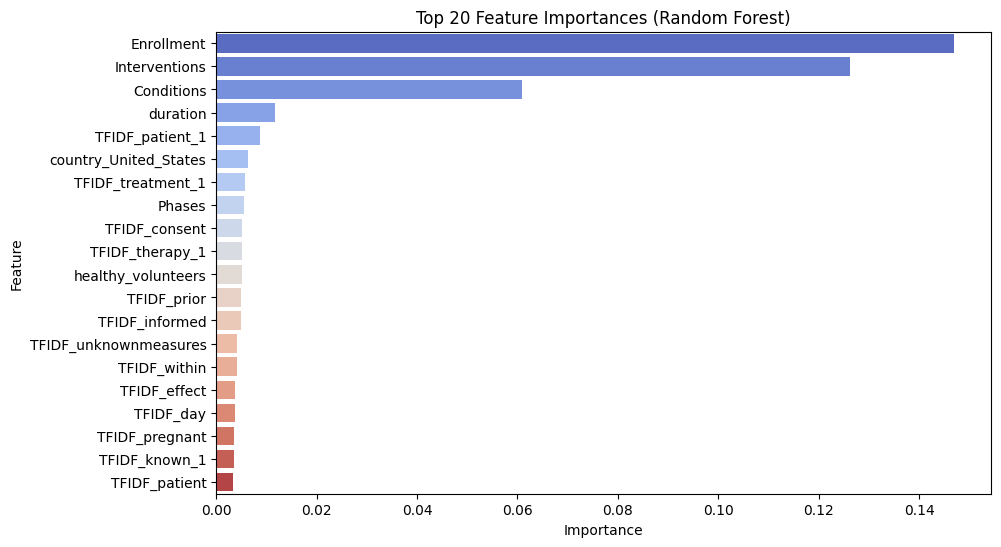

In [64]:
feature_importance_rf = pd.DataFrame({
    'feature': X_train_reduced.columns,
    'importance': rf_baseline.feature_importances_
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_importance_rf['importance'][:20], y=feature_importance_rf['feature'][:20], palette="coolwarm")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 20 Feature Importances (Random Forest)")
plt.show()


LIME

In [ ]:
import lime
import lime.lime_tabular
import shap

# LIME
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_reduced.values,
    feature_names=X_train_reduced.columns,
    class_names=["Non-Completed", "Completed"],
    mode="classification"
)

i = 10  # Just an example instance, you can select any instance from validation set
explanation = explainer_lime.explain_instance(X_val_reduced.iloc[i].values, rf_baseline.predict_proba)

# Show LIME explanation
explanation.show_in_notebook(show_table=True, show_all=False)

# You can also visualize the LIME explanation
explanation.as_pyplot_figure()
plt.show()

XGBOOST HYPER-CHECK-TF-IDF


🔹 Optimized XGBoost Model Performance:
✅ Accuracy: 0.9429
✅ AUC-ROC Score: 0.9596

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.60      0.75      7267
           1       0.94      1.00      0.97     44249

    accuracy                           0.94     51516
   macro avg       0.96      0.80      0.86     51516
weighted avg       0.95      0.94      0.94     51516



<Figure size 1200x600 with 0 Axes>

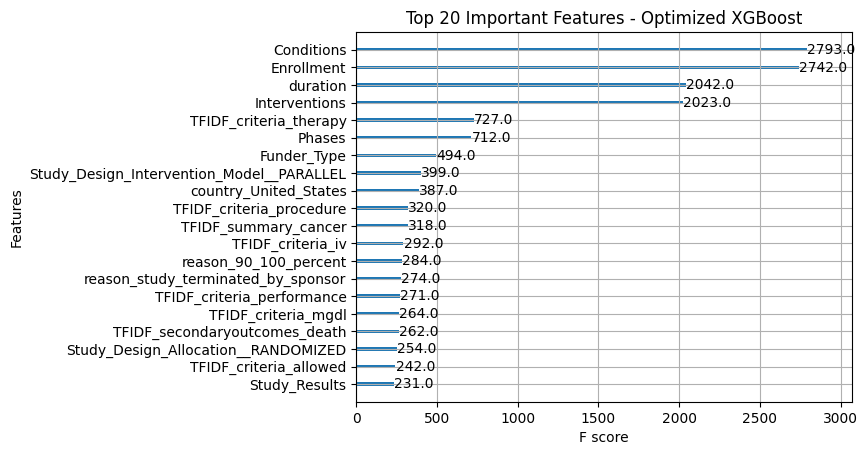

In [39]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt

# Calculate the scale_pos_weight for the minority class ("NON COMPLETED")
scale_pos_weight = sum(y_train == 1) / sum(y_train == 0)  # Ratio of completed to non-completed

# Define the optimized XGBoost classifier with scale_pos_weight to address imbalance
xgb_optimized = xgb.XGBClassifier(
    n_estimators=238, 
    max_depth=8, 
    learning_rate=0.0584, 
    random_state=42,
    eval_metric="logloss",
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight  # Apply scale_pos_weight to adjust for imbalance
)

# Train the model
xgb_optimized.fit(X_train_reduced, y_train)

# Predictions on validation set
y_pred_xgb_opt = xgb_optimized.predict(X_val_reduced)
y_pred_proba_xgb_opt = xgb_optimized.predict_proba(X_val_reduced)[:, 1]

# Performance metrics
accuracy_xgb_opt = accuracy_score(y_val, y_pred_xgb_opt)
roc_auc_xgb_opt = roc_auc_score(y_val, y_pred_proba_xgb_opt)

# Displaying the model performance
print("\n🔹 Optimized XGBoost Model Performance:")
print(f"✅ Accuracy: {accuracy_xgb_opt:.4f}")
print(f"✅ AUC-ROC Score: {roc_auc_xgb_opt:.4f}")

# Classification report
print("\n📊 Classification Report:")
print(classification_report(y_val, y_pred_xgb_opt))

# Plotting the feature importance
plt.figure(figsize=(12, 6))
xgb.plot_importance(xgb_optimized, max_num_features=20, importance_type="weight")
plt.title("Top 20 Important Features - Optimized XGBoost")
plt.show()


In [ ]:
xgb_model = xgb.XGBClassifier(
    n_estimators=500,  
    learning_rate=0.05,  
    max_depth=10,  
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight= y_train.value_counts()[0] / y_train.value_counts()[1]  # Handle class imbalance
)

xgb_model.fit(X_train_reduced, y_train)

y_pred = xgb_model.predict(X_val_reduced)
y_pred_proba = xgb_model.predict_proba(X_val_reduced)[:, 1]  # Probability for class 1
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred_proba)

print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print(f"✅ AUC-ROC: {auc:.4f}")

print("\n📌 Classification Report:\n", classification_report(y_val, y_pred))

tests

✅ Accuracy: 0.9210
✅ Precision: 0.9692
✅ Recall: 0.9378
✅ F1 Score: 0.9533
✅ AUC-ROC: 0.9594

📌 Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.82      0.75      7267
           1       0.97      0.94      0.95     44249

    accuracy                           0.92     51516
   macro avg       0.83      0.88      0.85     51516
weighted avg       0.93      0.92      0.92     51516



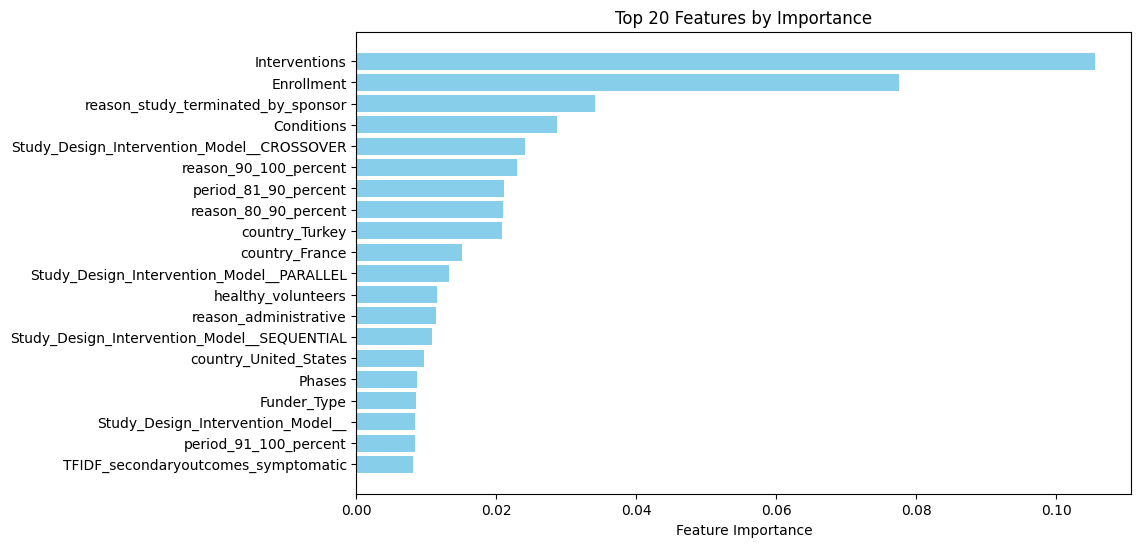

Interventions: 0.1054
Enrollment: 0.0774
reason_study_terminated_by_sponsor: 0.0340
Conditions: 0.0286
Study_Design_Intervention_Model__CROSSOVER: 0.0240
reason_90_100_percent: 0.0230
period_81_90_percent: 0.0211
reason_80_90_percent: 0.0209
country_Turkey: 0.0208
country_France: 0.0151
Study_Design_Intervention_Model__PARALLEL: 0.0133
healthy_volunteers: 0.0115
reason_administrative: 0.0113
Study_Design_Intervention_Model__SEQUENTIAL: 0.0108
country_United_States: 0.0097
Phases: 0.0086
Funder_Type: 0.0085
Study_Design_Intervention_Model__: 0.0084
period_91_100_percent: 0.0083
TFIDF_secondaryoutcomes_symptomatic: 0.0081


In [ ]:
#initial model m- aacha model- amazing
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Define and train the XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=500,  
    learning_rate=0.05,  
    max_depth=10,  
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight= y_train.value_counts()[0] / y_train.value_counts()[1]  # Handle class imbalance
)

xgb_model.fit(X_train_reduced, y_train)

# Make predictions
y_pred = xgb_model.predict(X_val_reduced)
y_pred_proba = xgb_model.predict_proba(X_val_reduced)[:, 1]  # Probability for class 1

# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred_proba)

# Print evaluation metrics
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print(f"✅ AUC-ROC: {auc:.4f}")

# Print classification report
print("\n📌 Classification Report:\n", classification_report(y_val, y_pred))

# Get feature importances from the model
importances = xgb_model.feature_importances_

# Get the indices of the top 20 most important features
indices = np.argsort(importances)[-20:][::-1]

# Get the names of the features (assuming your feature columns are stored in X_train_reduced.columns)
top_features = X_train_reduced.columns[indices]

# Plot the top 20 features
plt.figure(figsize=(10, 6))
plt.barh(top_features, importances[indices], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top 20 Features by Importance')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top
plt.show()

# Display the top 20 features and their importances
for feature, importance in zip(top_features, importances[indices]):
    print(f"{feature}: {importance:.4f}")


✅ Accuracy: 0.9358
✅ Precision: 0.9636
✅ Recall: 0.9616
✅ F1 Score: 0.9626
✅ AUC-ROC: 0.9594

📌 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.78      0.77      7267
           1       0.96      0.96      0.96     44249

    accuracy                           0.94     51516
   macro avg       0.87      0.87      0.87     51516
weighted avg       0.94      0.94      0.94     51516



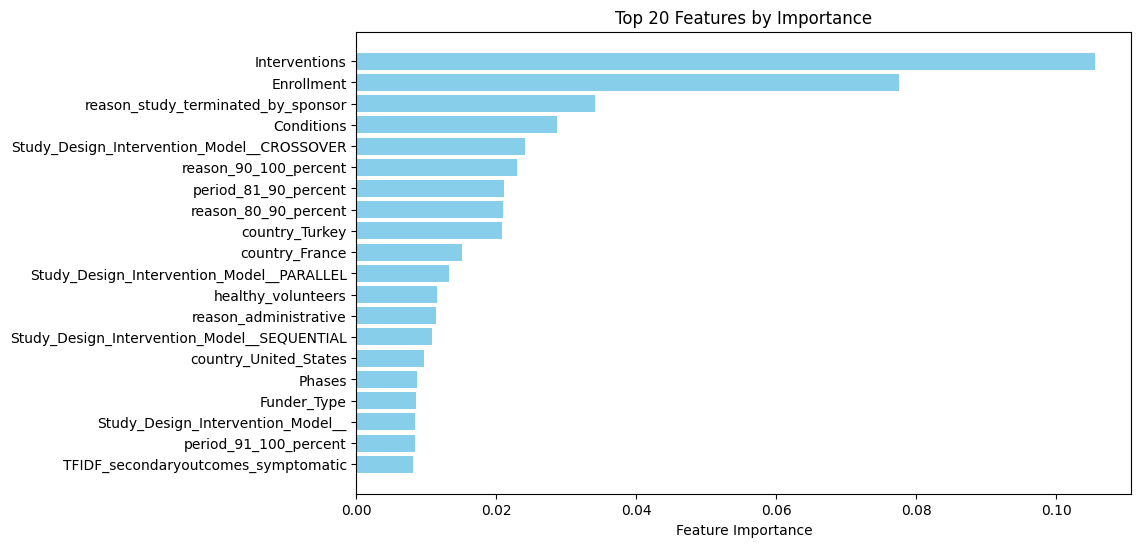

Interventions: 0.1054
Enrollment: 0.0774
reason_study_terminated_by_sponsor: 0.0340
Conditions: 0.0286
Study_Design_Intervention_Model__CROSSOVER: 0.0240
reason_90_100_percent: 0.0230
period_81_90_percent: 0.0211
reason_80_90_percent: 0.0209
country_Turkey: 0.0208
country_France: 0.0151
Study_Design_Intervention_Model__PARALLEL: 0.0133
healthy_volunteers: 0.0115
reason_administrative: 0.0113
Study_Design_Intervention_Model__SEQUENTIAL: 0.0108
country_United_States: 0.0097
Phases: 0.0086
Funder_Type: 0.0085
Study_Design_Intervention_Model__: 0.0084
period_91_100_percent: 0.0083
TFIDF_secondaryoutcomes_symptomatic: 0.0081


In [51]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Define and train the XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=500,  
    learning_rate=0.05,  
    max_depth=10,  
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight= y_train.value_counts()[0] / y_train.value_counts()[1]  # Handle class imbalance
)

xgb_model.fit(X_train_reduced, y_train)

# Make predictions
y_pred_proba = xgb_model.predict_proba(X_val_reduced)[:, 1]  # Probability for class 1

# You can adjust the threshold here. For example, use 0.4 instead of 0.5
threshold = 0.4
y_pred = (y_pred_proba >= threshold).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred_proba)

# Print evaluation metrics
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print(f"✅ AUC-ROC: {auc:.4f}")

# Print classification report
print("\n📌 Classification Report:\n", classification_report(y_val, y_pred))

# Get feature importances from the model
importances = xgb_model.feature_importances_

# Get the indices of the top 20 most important features
indices = np.argsort(importances)[-20:][::-1]

# Get the names of the features (assuming your feature columns are stored in X_train_reduced.columns)
top_features = X_train_reduced.columns[indices]

# Plot the top 20 features
plt.figure(figsize=(10, 6))
plt.barh(top_features, importances[indices], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top 20 Features by Importance')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top
plt.show()

# Display the top 20 features and their importances
for feature, importance in zip(top_features, importances[indices]):
    print(f"{feature}: {importance:.4f}")


In [49]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import numpy as np

# Apply SMOTE to balance the dataset
smote = SMOTE(sampling_strategy=0.8, random_state=42)  # Adjusting ratio
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_reduced, y_train)

# Adjusted scale_pos_weight (since after SMOTE, the ratio has changed)
new_class_ratio = y_train_balanced.value_counts()[0] / y_train_balanced.value_counts()[1]

# Improved Hyperparameters
xgb_model = xgb.XGBClassifier(
    n_estimators=600,  
    learning_rate=0.03,  # Slightly lowered for better generalization
    max_depth=8,  # Reduced to prevent overfitting
    min_child_weight=3,  # Helps regularization
    subsample=0.85,
    colsample_bytree=0.85,
    gamma=1,  # Helps reduce overfitting
    random_state=42,
    scale_pos_weight=new_class_ratio  # Updated for better class balance
)

# Train the model on the balanced dataset
xgb_model.fit(X_train_balanced, y_train_balanced)

# Predict on validation data
y_pred = xgb_model.predict(X_val_reduced)
y_pred_proba = xgb_model.predict_proba(X_val_reduced)[:, 1]  # Probability for class 1

# Adjusting Classification Threshold for Better Recall & F1
threshold = 0.4  # Slightly lower than 0.5 to increase recall
y_pred_adjusted = (y_pred_proba > threshold).astype(int)

# Evaluate Model Performance
accuracy = accuracy_score(y_val, y_pred_adjusted)
precision = precision_score(y_val, y_pred_adjusted)
recall = recall_score(y_val, y_pred_adjusted)
f1 = f1_score(y_val, y_pred_adjusted)
auc = roc_auc_score(y_val, y_pred_proba)

print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print(f"✅ AUC-ROC: {auc:.4f}")

print("\n📌 Classification Report:\n", classification_report(y_val, y_pred_adjusted))

✅ Accuracy: 0.9466
✅ Precision: 0.9532
✅ Recall: 0.9862
✅ F1 Score: 0.9694
✅ AUC-ROC: 0.9563

📌 Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.71      0.79      7267
           1       0.95      0.99      0.97     44249

    accuracy                           0.95     51516
   macro avg       0.92      0.85      0.88     51516
weighted avg       0.94      0.95      0.94     51516



In [46]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Function to evaluate and print metrics
def evaluate_model(model, X, y, name="Model"):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]
    
    print(f"\n=== {name} Results ===")
    print(f"✅ Accuracy: {accuracy_score(y, y_pred):.4f}")
    print(f"✅ Precision: {precision_score(y, y_pred):.4f}")
    print(f"✅ Recall: {recall_score(y, y_pred):.4f}")
    print(f"✅ F1 Score: {f1_score(y, y_pred):.4f}")
    print(f"✅ AUC-ROC: {roc_auc_score(y, y_pred_proba):.4f}")
    print("\n📌 Classification Report:\n", classification_report(y, y_pred))

# 1. Adjusted class weights and threshold
xgb_model_1 = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=8,  # Increased class weight
)

# 2. More aggressive model
xgb_model_2 = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=12,
    min_child_weight=1,
    gamma=0.5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=10,  # Even higher class weight
)

# Train and evaluate both models
models = [xgb_model_1, xgb_model_2]
names = ["Model with Adjusted Weights", "Aggressive Model"]

for model, name in zip(models, names):
    model.fit(X_train_reduced, y_train)
    
    # First evaluate with default threshold
    evaluate_model(model, X_val_reduced, y_val, f"{name} (Default Threshold)")
    
    # Then evaluate with lower threshold to improve recall
    y_pred_proba = model.predict_proba(X_val_reduced)[:, 1]
    thresholds = [0.3, 0.4]  # Try different thresholds
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        print(f"\n=== {name} (Threshold {threshold}) ===")
        print(f"✅ Accuracy: {accuracy_score(y_val, y_pred):.4f}")
        print(f"✅ Precision: {precision_score(y_val, y_pred):.4f}")
        print(f"✅ Recall: {recall_score(y_val, y_pred):.4f}")
        print(f"✅ F1 Score: {f1_score(y_val, y_pred):.4f}")
        print(f"✅ AUC-ROC: {roc_auc_score(y_val, y_pred_proba):.4f}")
        print("\n📌 Classification Report:\n", classification_report(y_val, y_pred))


=== Model with Adjusted Weights (Default Threshold) Results ===
✅ Accuracy: 0.9437
✅ Precision: 0.9397
✅ Recall: 0.9986
✅ F1 Score: 0.9682
✅ AUC-ROC: 0.9601

📌 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.61      0.75      7267
           1       0.94      1.00      0.97     44249

    accuracy                           0.94     51516
   macro avg       0.96      0.80      0.86     51516
weighted avg       0.95      0.94      0.94     51516


=== Model with Adjusted Weights (Threshold 0.3) ===
✅ Accuracy: 0.9407
✅ Precision: 0.9360
✅ Recall: 0.9993
✅ F1 Score: 0.9666
✅ AUC-ROC: 0.9601

📌 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.58      0.74      7267
           1       0.94      1.00      0.97     44249

    accuracy                           0.94     51516
   macro avg       0.96      0.79      0.85     51516
weighted avg       0.94      0.94      0.93

tests end


🔹 Optimized XGBoost Model Performance:
✅ Accuracy: 0.9488
✅ AUC-ROC Score: 0.9601

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.69      0.79      7267
           1       0.95      0.99      0.97     44249

    accuracy                           0.95     51516
   macro avg       0.94      0.84      0.88     51516
weighted avg       0.95      0.95      0.95     51516



<Figure size 1200x600 with 0 Axes>

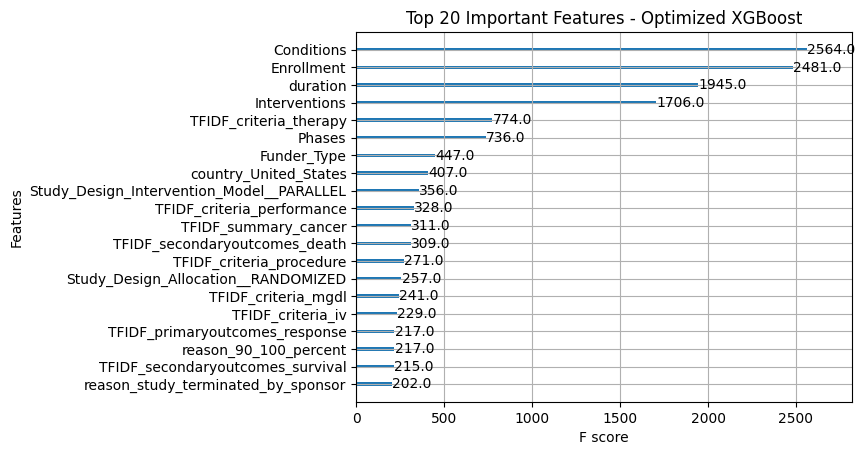

In [ ]:
#good code ig - code we were using
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt

xgb_optimized = xgb.XGBClassifier(
    n_estimators=238, 
    max_depth=8, 
    learning_rate=0.0584, 
    random_state=42,
    eval_metric="logloss",
    use_label_encoder=False
)

xgb_optimized.fit(X_train_reduced, y_train)

y_pred_xgb_opt = xgb_optimized.predict(X_val_reduced)
y_pred_proba_xgb_opt = xgb_optimized.predict_proba(X_val_reduced)[:, 1]

accuracy_xgb_opt = accuracy_score(y_val, y_pred_xgb_opt)
roc_auc_xgb_opt = roc_auc_score(y_val, y_pred_proba_xgb_opt)

print("\n🔹 Optimized XGBoost Model Performance:")
print(f"✅ Accuracy: {accuracy_xgb_opt:.4f}")
print(f"✅ AUC-ROC Score: {roc_auc_xgb_opt:.4f}")

print("\n📊 Classification Report:")
print(classification_report(y_val, y_pred_xgb_opt))

plt.figure(figsize=(12, 6))
xgb.plot_importance(xgb_optimized, max_num_features=20, importance_type="weight")
plt.title("Top 20 Important Features - Optimized XGBoost")
plt.show()

<Figure size 1200x600 with 0 Axes>

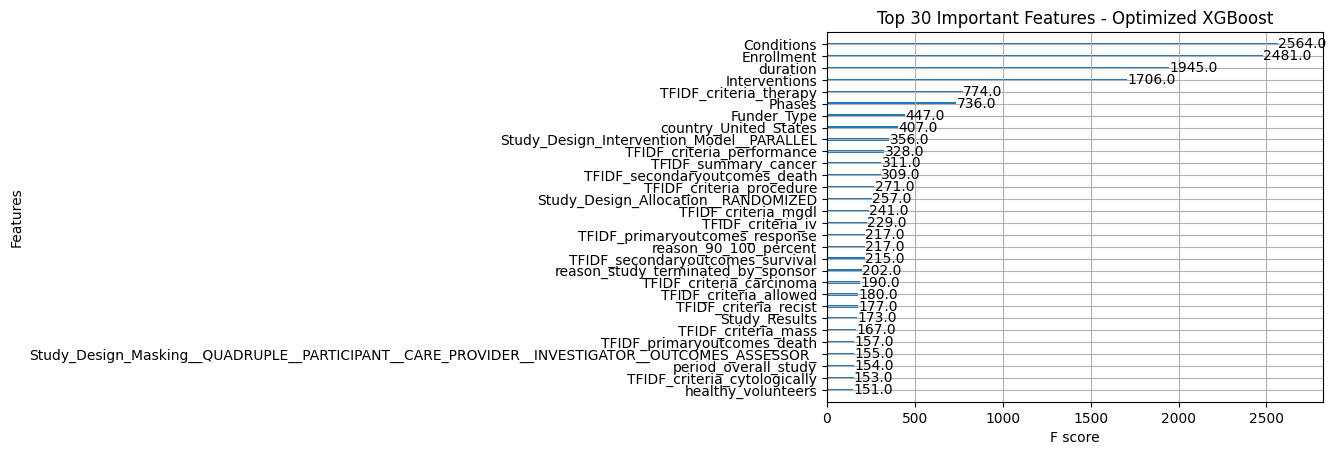

In [20]:
plt.figure(figsize=(12, 6))
xgb.plot_importance(xgb_optimized, max_num_features=30, importance_type="weight")
plt.title("Top 30 Important Features - Optimized XGBoost")
plt.show()

LIME

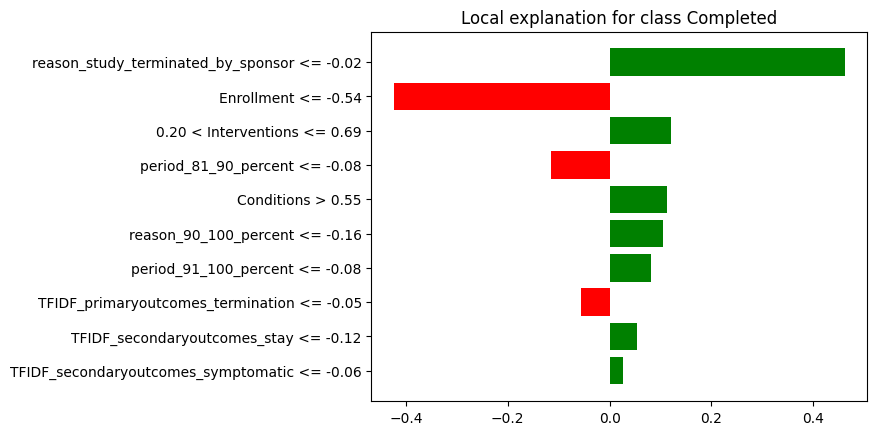

In [25]:
import lime
import lime.lime_tabular

# LIME explanation
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_reduced.values,
    feature_names=X_train_reduced.columns,
    class_names=["Non-Completed", "Completed"],
    mode="classification"
)

# Explain an individual prediction (for instance at index 10)
i = 10  # You can change this index based on the instance you want to explain
explanation = explainer_lime.explain_instance(X_val_reduced.iloc[i].values, xgb_optimized.predict_proba)

# Show LIME explanation in a notebook (interactive)
explanation.show_in_notebook(show_table=True, show_all=False)

# Plot the explanation
explanation.as_pyplot_figure()
plt.show()


In [53]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

def compare_models(original_model, X_train, X_val, y_train, y_val, n_features=20):
    """
    Compare original model performance with a model trained on top n features.
    """
    # Get predictions from original model
    original_pred = original_model.predict(X_val)
    original_pred_proba = original_model.predict_proba(X_val)[:, 1]
    
    # Get original model metrics
    original_accuracy = accuracy_score(y_val, original_pred)
    original_roc_auc = roc_auc_score(y_val, original_pred_proba)
    
    # Get top features
    importances = original_model.feature_importances_
    feature_importance = list(zip(X_train.columns, importances))
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    top_features = [feature[0] for feature in feature_importance[:n_features]]
    
    # Train new model with top features
    X_train_selected = X_train[top_features]
    X_val_selected = X_val[top_features]
    
    new_model = xgb.XGBClassifier(
        n_estimators=original_model.n_estimators,
        max_depth=original_model.max_depth,
        learning_rate=original_model.learning_rate,
        random_state=42,
        eval_metric="logloss",
        use_label_encoder=False
    )
    
    new_model.fit(X_train_selected, y_train)
    
    # Get predictions from new model
    new_pred = new_model.predict(X_val_selected)
    new_pred_proba = new_model.predict_proba(X_val_selected)[:, 1]
    
    # Get new model metrics
    new_accuracy = accuracy_score(y_val, new_pred)
    new_roc_auc = roc_auc_score(y_val, new_pred_proba)
    
    # Print comparison
    print("\n📊 Model Performance Comparison")
    print("-" * 50)
    print("Original Model (all features):")
    print(f"✅ Accuracy: {original_accuracy:.4f}")
    print(f"✅ AUC-ROC: {original_roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_val, original_pred))
    
    print("\nTop 20 Features Model:")
    print(f"✅ Accuracy: {new_accuracy:.4f}")
    print(f"✅ AUC-ROC: {new_roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_val, new_pred))
    
    print("\n🔝 Top 20 Features Used:")
    for i, (feature, importance) in enumerate(feature_importance[:n_features], 1):
        print(f"{i}. {feature}: {importance:.4f}")
    
    return {
        'original_metrics': {
            'accuracy': original_accuracy,
            'roc_auc': original_roc_auc
        },
        'new_metrics': {
            'accuracy': new_accuracy,
            'roc_auc': new_roc_auc
        },
        'top_features': top_features,
        'new_model': new_model
    }

# Run comparison
results = compare_models(
    original_model=xgb_optimized,
    X_train=X_train_reduced,
    X_val=X_val_reduced,
    y_train=y_train,
    y_val=y_val
)


📊 Model Performance Comparison
--------------------------------------------------
Original Model (all features):
✅ Accuracy: 0.9488
✅ AUC-ROC: 0.9601

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.69      0.79      7267
           1       0.95      0.99      0.97     44249

    accuracy                           0.95     51516
   macro avg       0.94      0.84      0.88     51516
weighted avg       0.95      0.95      0.95     51516


Top 20 Features Model:
✅ Accuracy: 0.9479
✅ AUC-ROC: 0.9562

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.69      0.79      7267
           1       0.95      0.99      0.97     44249

    accuracy                           0.95     51516
   macro avg       0.94      0.84      0.88     51516
weighted avg       0.95      0.95      0.94     51516


🔝 Top 20 Features Used:
1. Interventions: 0.1475
2. Enrollment: 0.1414
3. Conditions:


🔹 Original Model Feature Importance:


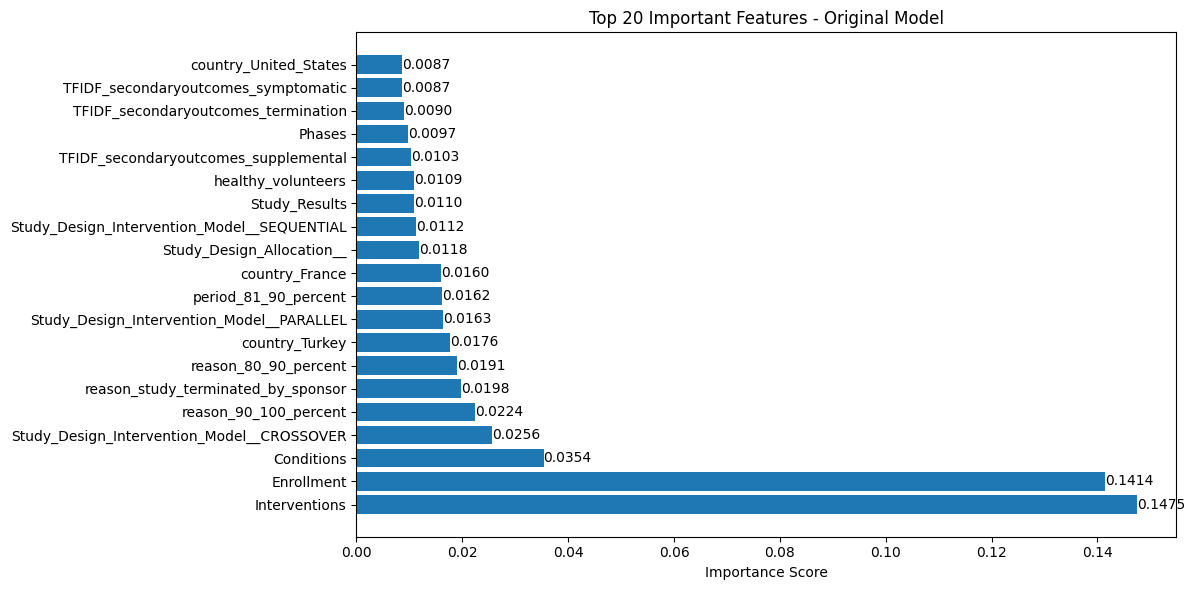


📊 Top 20 Features and Their Importance Scores:
1. Interventions: 0.1475
2. Enrollment: 0.1414
3. Conditions: 0.0354
4. Study_Design_Intervention_Model__CROSSOVER: 0.0256
5. reason_90_100_percent: 0.0224
6. reason_study_terminated_by_sponsor: 0.0198
7. reason_80_90_percent: 0.0191
8. country_Turkey: 0.0176
9. Study_Design_Intervention_Model__PARALLEL: 0.0163
10. period_81_90_percent: 0.0162
11. country_France: 0.0160
12. Study_Design_Allocation__: 0.0118
13. Study_Design_Intervention_Model__SEQUENTIAL: 0.0112
14. Study_Results: 0.0110
15. healthy_volunteers: 0.0109
16. TFIDF_secondaryoutcomes_supplemental: 0.0103
17. Phases: 0.0097
18. TFIDF_secondaryoutcomes_termination: 0.0090
19. TFIDF_secondaryoutcomes_symptomatic: 0.0087
20. country_United_States: 0.0087

🔹 New Model (Top 20 Features) Feature Importance:


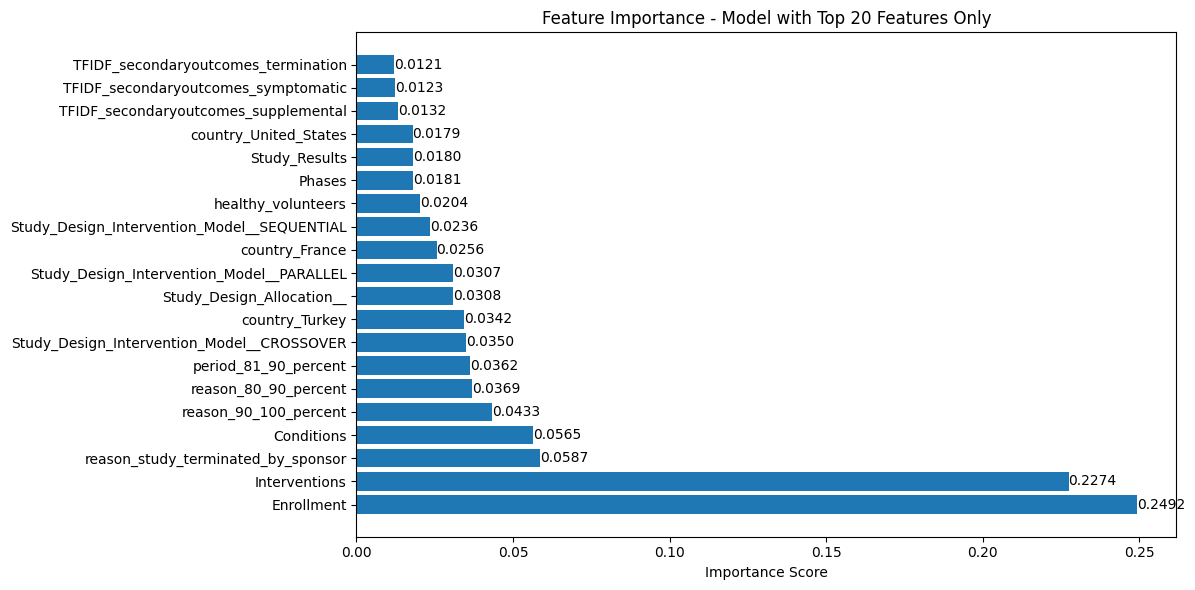


📊 Top 20 Features and Their Importance Scores:
1. Enrollment: 0.2492
2. Interventions: 0.2274
3. reason_study_terminated_by_sponsor: 0.0587
4. Conditions: 0.0565
5. reason_90_100_percent: 0.0433
6. reason_80_90_percent: 0.0369
7. period_81_90_percent: 0.0362
8. Study_Design_Intervention_Model__CROSSOVER: 0.0350
9. country_Turkey: 0.0342
10. Study_Design_Allocation__: 0.0308
11. Study_Design_Intervention_Model__PARALLEL: 0.0307
12. country_France: 0.0256
13. Study_Design_Intervention_Model__SEQUENTIAL: 0.0236
14. healthy_volunteers: 0.0204
15. Phases: 0.0181
16. Study_Results: 0.0180
17. country_United_States: 0.0179
18. TFIDF_secondaryoutcomes_supplemental: 0.0132
19. TFIDF_secondaryoutcomes_symptomatic: 0.0123
20. TFIDF_secondaryoutcomes_termination: 0.0121

📊 Original Model (All Features) Performance:
✅ Accuracy: 0.9488
✅ AUC-ROC: 0.9601

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.69      0.79      7267
           1  

In [54]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt

def plot_feature_importance(model, feature_names, title, n_features=20):
    """
    Plot feature importance for a model and return top features.
    """
    # Get feature importances
    importances = model.feature_importances_
    feature_importance = list(zip(feature_names, importances))
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    top_features = feature_importance[:n_features]
    
    # Prepare data for plotting
    features, scores = zip(*top_features)
    
    # Create figure
    plt.figure(figsize=(12, 6))
    y_pos = np.arange(len(features))
    
    # Create horizontal bar plot
    plt.barh(y_pos, scores, align='center')
    plt.yticks(y_pos, features)
    plt.xlabel('Importance Score')
    plt.title(title)
    
    # Add value labels on the bars
    for i, v in enumerate(scores):
        plt.text(v, i, f'{v:.4f}', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # Print feature importance scores
    print(f"\n📊 Top {n_features} Features and Their Importance Scores:")
    for i, (feature, importance) in enumerate(top_features, 1):
        print(f"{i}. {feature}: {importance:.4f}")
    
    return [feature[0] for feature in top_features]

# First, plot and get top features from original model
print("\n🔹 Original Model Feature Importance:")
original_top_features = plot_feature_importance(
    xgb_optimized, 
    X_train_reduced.columns, 
    "Top 20 Important Features - Original Model"
)

# Now train new model with only top 20 features and show its feature importance
X_train_selected = X_train_reduced[original_top_features]
X_val_selected = X_val_reduced[original_top_features]

new_model = xgb.XGBClassifier(
    n_estimators=xgb_optimized.n_estimators,
    max_depth=xgb_optimized.max_depth,
    learning_rate=xgb_optimized.learning_rate,
    random_state=42,
    eval_metric="logloss",
    use_label_encoder=False
)

new_model.fit(X_train_selected, y_train)

print("\n🔹 New Model (Top 20 Features) Feature Importance:")
plot_feature_importance(
    new_model, 
    original_top_features, 
    "Feature Importance - Model with Top 20 Features Only"
)

# Compare performance metrics
def print_model_performance(model, X, y, model_name):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]
    
    accuracy = accuracy_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred_proba)
    
    print(f"\n📊 {model_name} Performance:")
    print(f"✅ Accuracy: {accuracy:.4f}")
    print(f"✅ AUC-ROC: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y, y_pred))

# Print performance comparison
print_model_performance(xgb_optimized, X_val_reduced, y_val, "Original Model (All Features)")
print_model_performance(new_model, X_val_selected, y_val, "New Model (Top 20 Features)")


🔹 Original Model Feature Importance:


<Figure size 1200x600 with 0 Axes>

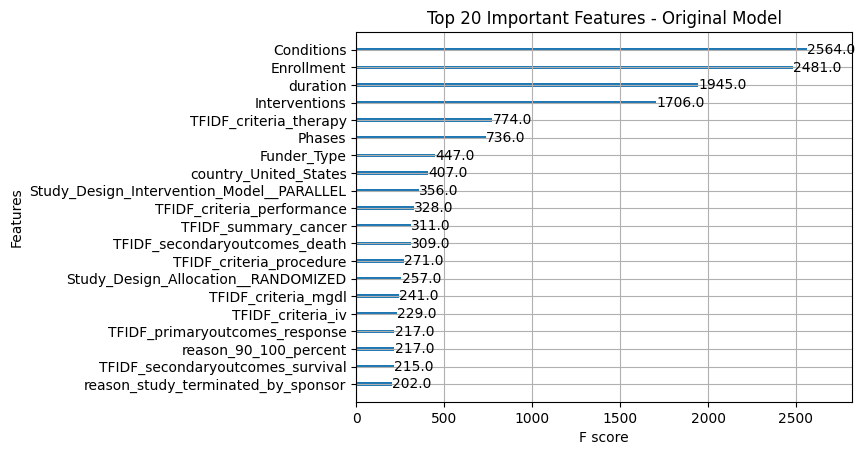


📊 Original Model Top 20 Features and Their Importance Scores:
1. Interventions: 0.1475
2. Enrollment: 0.1414
3. Conditions: 0.0354
4. Study_Design_Intervention_Model__CROSSOVER: 0.0256
5. reason_90_100_percent: 0.0224
6. reason_study_terminated_by_sponsor: 0.0198
7. reason_80_90_percent: 0.0191
8. country_Turkey: 0.0176
9. Study_Design_Intervention_Model__PARALLEL: 0.0163
10. period_81_90_percent: 0.0162
11. country_France: 0.0160
12. Study_Design_Allocation__: 0.0118
13. Study_Design_Intervention_Model__SEQUENTIAL: 0.0112
14. Study_Results: 0.0110
15. healthy_volunteers: 0.0109
16. TFIDF_secondaryoutcomes_supplemental: 0.0103
17. Phases: 0.0097
18. TFIDF_secondaryoutcomes_termination: 0.0090
19. TFIDF_secondaryoutcomes_symptomatic: 0.0087
20. country_United_States: 0.0087

🔹 New Model (Top 20 Features) Feature Importance:


<Figure size 1200x600 with 0 Axes>

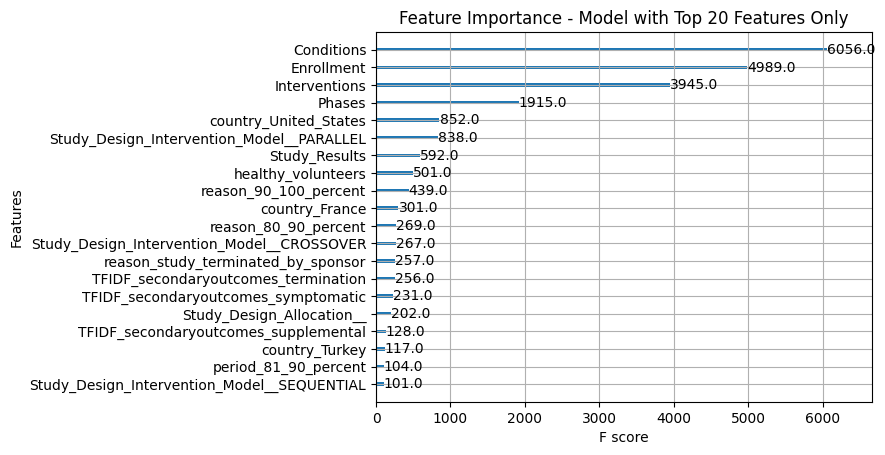


📊 Original Model (All Features) Performance:
✅ Accuracy: 0.9488
✅ AUC-ROC: 0.9601

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.69      0.79      7267
           1       0.95      0.99      0.97     44249

    accuracy                           0.95     51516
   macro avg       0.94      0.84      0.88     51516
weighted avg       0.95      0.95      0.95     51516


📊 New Model (Top 20 Features) Performance:
✅ Accuracy: 0.9479
✅ AUC-ROC: 0.9562

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.69      0.79      7267
           1       0.95      0.99      0.97     44249

    accuracy                           0.95     51516
   macro avg       0.94      0.84      0.88     51516
weighted avg       0.95      0.95      0.94     51516



In [56]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt

def plot_and_compare_models(original_model, X_train, X_val, y_train, y_val):
    """
    Plot feature importance using XGBoost's built-in method and compare models
    """
    # Plot original model's feature importance
    print("\n🔹 Original Model Feature Importance:")
    plt.figure(figsize=(12, 6))
    xgb.plot_importance(original_model, max_num_features=20, importance_type="weight")
    plt.title("Top 20 Important Features - Original Model")
    plt.show()
    
    # Get top 20 features using feature_importances_
    importance_pairs = list(zip(X_train.columns, original_model.feature_importances_))
    importance_pairs.sort(key=lambda x: x[1], reverse=True)
    top_features = [pair[0] for pair in importance_pairs[:20]]
    
    # Print original feature importance scores
    print("\n📊 Original Model Top 20 Features and Their Importance Scores:")
    for i, (feature, importance) in enumerate(importance_pairs[:20], 1):
        print(f"{i}. {feature}: {importance:.4f}")
    
    # Train new model with top 20 features
    X_train_selected = X_train[top_features]
    X_val_selected = X_val[top_features]
    
    new_model = xgb.XGBClassifier(
        n_estimators=original_model.n_estimators,
        max_depth=original_model.max_depth,
        learning_rate=original_model.learning_rate,
        random_state=42,
        eval_metric="logloss",
        use_label_encoder=False
    )
    
    new_model.fit(X_train_selected, y_train)
    
    # Plot new model's feature importance
    print("\n🔹 New Model (Top 20 Features) Feature Importance:")
    plt.figure(figsize=(12, 6))
    xgb.plot_importance(new_model, max_num_features=20, importance_type="weight")
    plt.title("Feature Importance - Model with Top 20 Features Only")
    plt.show()
    
    # Compare performance metrics
    def print_model_performance(model, X, y, model_name):
        y_pred = model.predict(X)
        y_pred_proba = model.predict_proba(X)[:, 1]
        
        accuracy = accuracy_score(y, y_pred)
        roc_auc = roc_auc_score(y, y_pred_proba)
        
        print(f"\n📊 {model_name} Performance:")
        print(f"✅ Accuracy: {accuracy:.4f}")
        print(f"✅ AUC-ROC: {roc_auc:.4f}")
        print("\nClassification Report:")
        print(classification_report(y, y_pred))
    
    # Print performance comparison
    print_model_performance(original_model, X_val_reduced, y_val, "Original Model (All Features)")
    print_model_performance(new_model, X_val_selected, y_val, "New Model (Top 20 Features)")
    
    return new_model, top_features

# Run comparison
new_model, top_features = plot_and_compare_models(
    original_model=xgb_optimized,
    X_train=X_train_reduced,
    X_val=X_val_reduced,
    y_train=y_train,
    y_val=y_val
)

Top 20 Features Selected for Model Retraining:
['Conditions', 'Enrollment', 'duration', 'Interventions', 'TFIDF_criteria_therapy', 'Phases', 'Funder_Type', 'country_United_States', 'Study_Design_Intervention_Model__PARALLEL', 'TFIDF_criteria_performance', 'TFIDF_summary_cancer', 'TFIDF_secondaryoutcomes_death', 'TFIDF_criteria_procedure', 'Study_Design_Allocation__RANDOMIZED', 'TFIDF_criteria_mgdl', 'TFIDF_criteria_iv', 'reason_90_100_percent', 'TFIDF_primaryoutcomes_response', 'TFIDF_secondaryoutcomes_survival', 'reason_study_terminated_by_sponsor']

🔹 XGBoost Model Performance (Top 20 Features):
✅ Accuracy: 0.9481
✅ AUC-ROC Score: 0.9567

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.69      0.79      7267
           1       0.95      0.99      0.97     44249

    accuracy                           0.95     51516
   macro avg       0.94      0.84      0.88     51516
weighted avg       0.95      0.95      0.94     51516


<Figure size 1200x600 with 0 Axes>

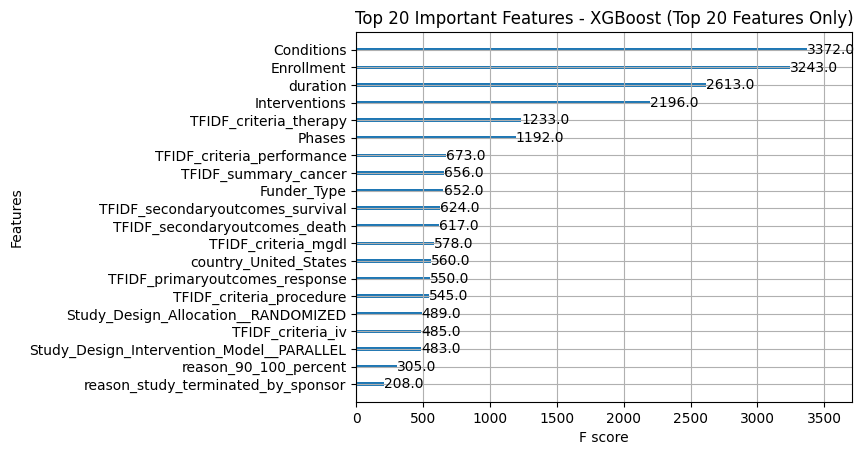

In [20]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt

# Get the top 20 important features based on the model's feature importance
top_20_features = xgb_optimized.get_booster().get_score(importance_type='weight')
top_20_features = sorted(top_20_features.items(), key=lambda x: x[1], reverse=True)[:20]
top_20_feature_names = [feature[0] for feature in top_20_features]

print("Top 20 Features Selected for Model Retraining:")
print(top_20_feature_names)

# Create a new dataset with only the top 20 features
X_train_top_20 = X_train_reduced[top_20_feature_names]
X_val_top_20 = X_val_reduced[top_20_feature_names]

# Train the model again using only the top 20 features
xgb_top_20_model = xgb.XGBClassifier(
    n_estimators=238,
    max_depth=8,
    learning_rate=0.0584,
    random_state=42,
    eval_metric="logloss",
    use_label_encoder=False
)

# Fit the model
xgb_top_20_model.fit(X_train_top_20, y_train)

# Make predictions with the top 20 feature model
y_pred_xgb_top_20 = xgb_top_20_model.predict(X_val_top_20)
y_pred_proba_xgb_top_20 = xgb_top_20_model.predict_proba(X_val_top_20)[:, 1]

# Evaluate model performance
accuracy_xgb_top_20 = accuracy_score(y_val, y_pred_xgb_top_20)
roc_auc_xgb_top_20 = roc_auc_score(y_val, y_pred_proba_xgb_top_20)

print("\n🔹 XGBoost Model Performance (Top 20 Features):")
print(f"✅ Accuracy: {accuracy_xgb_top_20:.4f}")
print(f"✅ AUC-ROC Score: {roc_auc_xgb_top_20:.4f}")

print("\n📊 Classification Report:")
print(classification_report(y_val, y_pred_xgb_top_20))

# Plot feature importance for the top 20 feature model
plt.figure(figsize=(12, 6))
xgb.plot_importance(xgb_top_20_model, max_num_features=20, importance_type="weight")
plt.title("Top 20 Important Features - XGBoost (Top 20 Features Only)")
plt.show()


Top 6 Features Selected for Model Retraining:
['Conditions', 'Enrollment', 'duration', 'Interventions', 'TFIDF_criteria_therapy', 'Phases']

🔹 XGBoost Model Performance (Top 6 Features):
✅ Accuracy: 0.9448
✅ AUC-ROC Score: 0.9513

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.66      0.77      7267
           1       0.95      0.99      0.97     44249

    accuracy                           0.94     51516
   macro avg       0.94      0.83      0.87     51516
weighted avg       0.94      0.94      0.94     51516



<Figure size 1200x600 with 0 Axes>

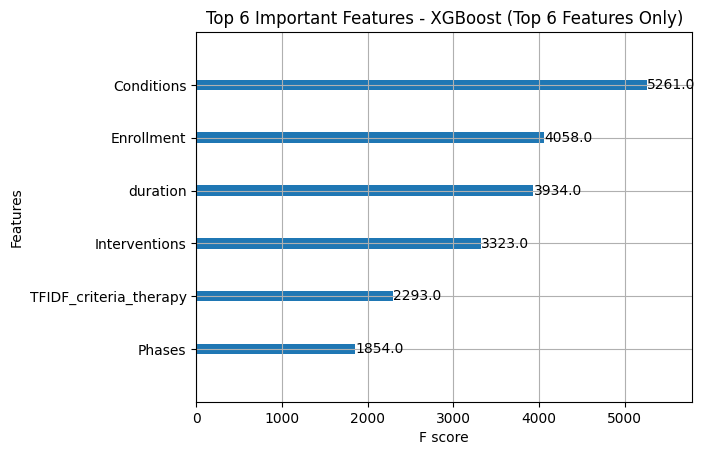

In [21]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt

# Specify the top 6 features
top_6_features = ['Conditions', 'Enrollment', 'duration', 'Interventions', 'TFIDF_criteria_therapy', 'Phases']

print("Top 6 Features Selected for Model Retraining:")
print(top_6_features)

# Create a new dataset with only the top 6 features
X_train_top_6 = X_train_reduced[top_6_features]
X_val_top_6 = X_val_reduced[top_6_features]

# Train the model again using only the top 6 features
xgb_top_6_model = xgb.XGBClassifier(
    n_estimators=238,
    max_depth=8,
    learning_rate=0.0584,
    random_state=42,
    eval_metric="logloss",
    use_label_encoder=False
)

# Fit the model
xgb_top_6_model.fit(X_train_top_6, y_train)

# Make predictions with the top 6 feature model
y_pred_xgb_top_6 = xgb_top_6_model.predict(X_val_top_6)
y_pred_proba_xgb_top_6 = xgb_top_6_model.predict_proba(X_val_top_6)[:, 1]

# Evaluate model performance
accuracy_xgb_top_6 = accuracy_score(y_val, y_pred_xgb_top_6)
roc_auc_xgb_top_6 = roc_auc_score(y_val, y_pred_proba_xgb_top_6)

print("\n🔹 XGBoost Model Performance (Top 6 Features):")
print(f"✅ Accuracy: {accuracy_xgb_top_6:.4f}")
print(f"✅ AUC-ROC Score: {roc_auc_xgb_top_6:.4f}")

print("\n📊 Classification Report:")
print(classification_report(y_val, y_pred_xgb_top_6))

# Plot feature importance for the top 6 feature model
plt.figure(figsize=(12, 6))
xgb.plot_importance(xgb_top_6_model, max_num_features=6, importance_type="weight")
plt.title("Top 6 Important Features - XGBoost (Top 6 Features Only)")
plt.show()


In [22]:
import pickle

# Save the trained XGBoost model to a pickle file
with open('xgb_top_6_model.pkl', 'wb') as f:
    pickle.dump(xgb_top_6_model, f)

print("XGBoost model (Top 6 Features) saved successfully.")


XGBoost model (Top 6 Features) saved successfully.


Top 6 Features Selected for Model Retraining:
['Conditions', 'Enrollment', 'duration', 'Interventions', 'TFIDF_criteria_therapy', 'Phases', 'Funder_Type', 'country_United_States', 'Study_Design_Intervention_Model__PARALLEL']

🔹 XGBoost Model Performance (Top 6 Features):
✅ Accuracy: 0.9466
✅ AUC-ROC Score: 0.9545

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.68      0.78      7267
           1       0.95      0.99      0.97     44249

    accuracy                           0.95     51516
   macro avg       0.94      0.83      0.88     51516
weighted avg       0.95      0.95      0.94     51516



<Figure size 1200x600 with 0 Axes>

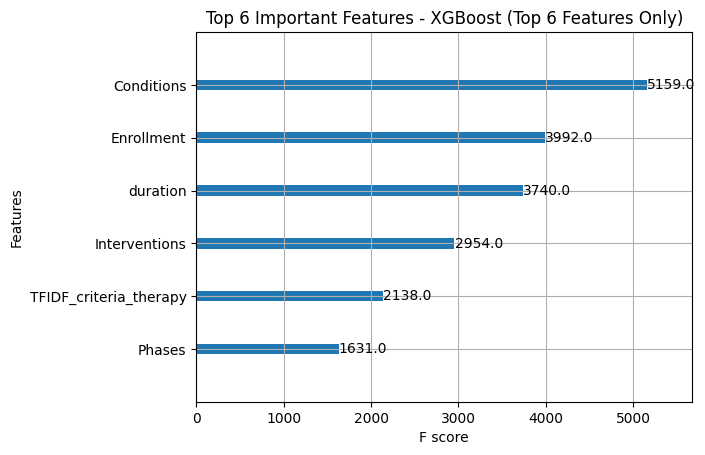

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt

# Specify the top 6 features
top_6_features = ['Conditions', 'Enrollment', 'duration', 'Interventions', 'TFIDF_criteria_therapy', 'Phases','Funder_Type', 'country_United_States', 'Study_Design_Intervention_Model__PARALLEL']

print("Top 6 Features Selected for Model Retraining:")
print(top_6_features)

# Create a new dataset with only the top 6 features
X_train_top_6 = X_train_reduced[top_6_features]
X_val_top_6 = X_val_reduced[top_6_features]

# Train the model again using only the top 6 features
xgb_top_6_model = xgb.XGBClassifier(
    n_estimators=238,
    max_depth=8,
    learning_rate=0.0584,
    random_state=42,
    eval_metric="logloss",
    use_label_encoder=False
)

# Fit the model
xgb_top_6_model.fit(X_train_top_6, y_train)

# Make predictions with the top 6 feature model
y_pred_xgb_top_6 = xgb_top_6_model.predict(X_val_top_6)
y_pred_proba_xgb_top_6 = xgb_top_6_model.predict_proba(X_val_top_6)[:, 1]

# Evaluate model performance
accuracy_xgb_top_6 = accuracy_score(y_val, y_pred_xgb_top_6)
roc_auc_xgb_top_6 = roc_auc_score(y_val, y_pred_proba_xgb_top_6)

print("\n🔹 XGBoost Model Performance (Top 6 Features):")
print(f"✅ Accuracy: {accuracy_xgb_top_6:.4f}")
print(f"✅ AUC-ROC Score: {roc_auc_xgb_top_6:.4f}")

print("\n📊 Classification Report:")
print(classification_report(y_val, y_pred_xgb_top_6))

# Plot feature importance for the top 6 feature model
plt.figure(figsize=(12, 6))
xgb.plot_importance(xgb_top_6_model, max_num_features=9, importance_type="weight")
plt.title("Top 6 Important Features - XGBoost (Top 6 Features Only)")
plt.show()


<Figure size 1200x600 with 0 Axes>

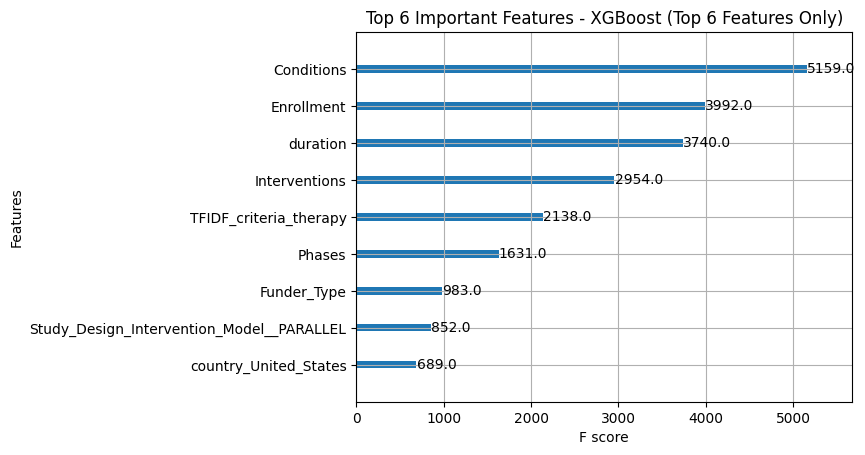

In [23]:
plt.figure(figsize=(12, 6))
xgb.plot_importance(xgb_top_6_model, max_num_features=9, importance_type="weight")
plt.title("Top 6 Important Features - XGBoost (Top 6 Features Only)")
plt.show()

SHAP

In [ ]:
import shap

# SHAP TreeExplainer for XGBoost model
explainer_shap = shap.TreeExplainer(xgb_optimized)

# SHAP values for the validation set
shap_values_xgb = explainer_shap.shap_values(X_val_reduced)

# Summary plot for global feature importance (showing the impact of features on the model's predictions)
shap.summary_plot(shap_values_xgb[1], X_val_reduced, feature_names=X_val_reduced.columns)

# Force plot for a specific instance (example index 10, same as LIME)
shap.initjs()
shap.force_plot(explainer_shap.expected_value[1], shap_values_xgb[1][i], X_val_reduced.iloc[i], feature_names=X_val_reduced.columns)


HyperParameter Tuning in Random Forest : Using Randomized Search with Cross Validation

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(class_weight="balanced", random_state=42),
    param_distributions=param_grid,
    n_iter=10,
    cv=3,
    verbose=2,
    n_jobs=1, 
    random_state=42
)


rf_random.fit(X_train_reduced, y_train)

print("Best Parameters Found:", rf_random.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 3.5min
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 3.4min
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 3.2min
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 3.0min
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 3.0min
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 3.1min
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 2.6min
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100;

In [57]:
rf_best = RandomForestClassifier(
    n_estimators=rf_random.best_params_["n_estimators"],
    max_depth=rf_random.best_params_["max_depth"],
    min_samples_split=rf_random.best_params_["min_samples_split"],
    min_samples_leaf=rf_random.best_params_["min_samples_leaf"],
    bootstrap=rf_random.best_params_["bootstrap"],
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf_best.fit(X_train_reduced, y_train)

y_pred_rf_best = rf_best.predict(X_val_reduced)
y_pred_proba_rf_best = rf_best.predict_proba(X_val_reduced)[:, 1]

print("Optimized Random Forest Model Trained")


Optimized Random Forest Model Trained


In [58]:
accuracy_rf_best = accuracy_score(y_val, y_pred_rf_best)
precision_rf_best = precision_score(y_val, y_pred_rf_best)
recall_rf_best = recall_score(y_val, y_pred_rf_best)
f1_rf_best = f1_score(y_val, y_pred_rf_best)
roc_auc_rf_best = roc_auc_score(y_val, y_pred_proba_rf_best)

print("\n Classification Report (Optimized Random Forest):")
print(classification_report(y_val, y_pred_rf_best))

print("\n Optimized Random Forest Performance Metrics:")
print(f"🔹 Accuracy: {accuracy_rf_best:.4f}")
print(f"🔹 Precision: {precision_rf_best:.4f}")
print(f"🔹 Recall: {recall_rf_best:.4f}")
print(f"🔹 F1 Score: {f1_rf_best:.4f}")
print(f"🔹 AUC-ROC: {roc_auc_rf_best:.4f}")



 Classification Report (Optimized Random Forest):
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     44249
           1       0.83      0.49      0.62      7267

    accuracy                           0.91     51516
   macro avg       0.88      0.74      0.78     51516
weighted avg       0.91      0.91      0.90     51516


 Optimized Random Forest Performance Metrics:
🔹 Accuracy: 0.9139
🔹 Precision: 0.8324
🔹 Recall: 0.4880
🔹 F1 Score: 0.6153
🔹 AUC-ROC: 0.8831


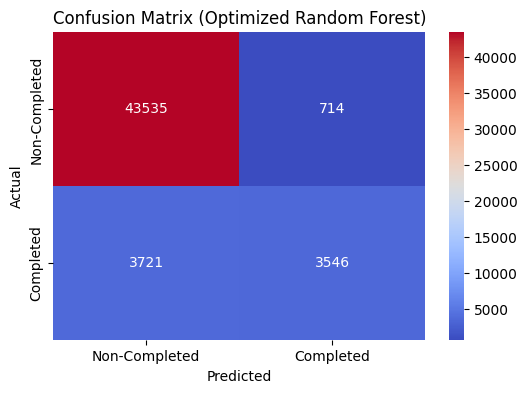

In [59]:
conf_matrix_rf_best = confusion_matrix(y_val, y_pred_rf_best)

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_rf_best, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Non-Completed", "Completed"], yticklabels=["Non-Completed", "Completed"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Optimized Random Forest)")
plt.show()


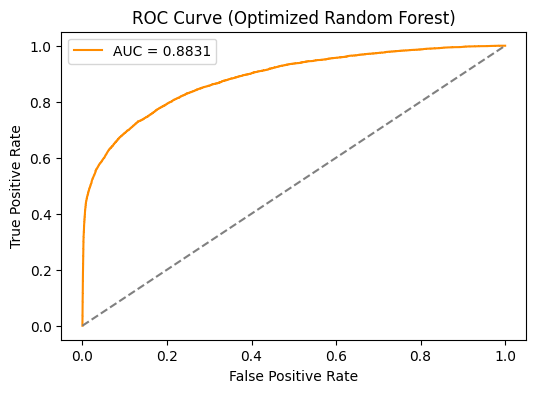

In [60]:
fpr_rf_best, tpr_rf_best, _ = roc_curve(y_val, y_pred_proba_rf_best)

plt.figure(figsize=(6,4))
plt.plot(fpr_rf_best, tpr_rf_best, label=f"AUC = {roc_auc_rf_best:.4f}", color="darkorange")
plt.plot([0,1], [0,1], linestyle="--", color="gray")  # Random Model Baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Optimized Random Forest)")
plt.legend()
plt.show()


LIME 

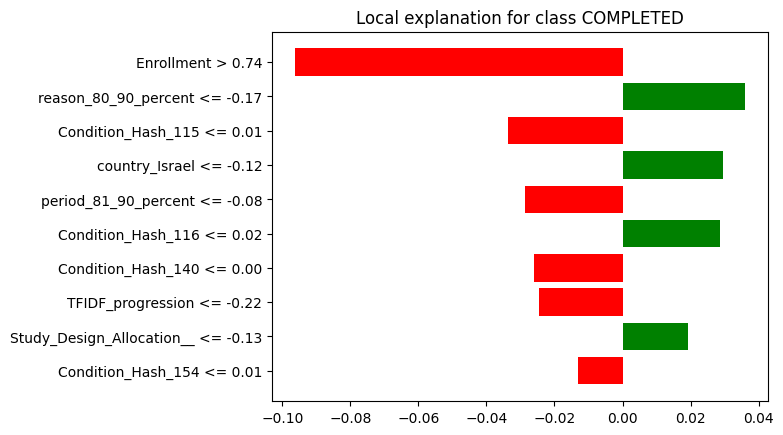

In [61]:
lime_exp_rf = lime_explainer.explain_instance(
    data_row=sample_instance.values,
    predict_fn=rf_best.predict_proba  
)

lime_exp_rf.show_in_notebook()
lime_exp_rf.as_pyplot_figure()
plt.show()


SHAP

In [ ]:
import shap

# Create a SHAP explainer for the RandomForestClassifier model
explainer_rf_best = shap.TreeExplainer(rf_best)

# Compute SHAP values for the validation set
shap_values_rf_best = explainer_rf_best.shap_values(X_val_reduced)

# Summary plot for global feature importance (showing the impact of features on the model's predictions)
shap.summary_plot(shap_values_rf_best[1], X_val_reduced, feature_names=X_val_reduced.columns)

# Force plot for a specific instance (e.g., instance at index 10)
shap.initjs()
shap.force_plot(explainer_rf_best.expected_value[1], shap_values_rf_best[1][10], X_val_reduced.iloc[10], feature_names=X_val_reduced.columns)


Hyperparameter Tuning with Optuna
This script uses Optuna for hyperparameter optimization to select the best classification model. It explores multiple models (Random Forest, XGBoost, and Logistic Regression) by sampling hyperparameters and evaluating performance using cross-validation. 

In [23]:
import optuna
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import optuna.visualization as vis
import matplotlib.pyplot as plt

def objective(trial):
    classifier_name = trial.suggest_categorical("classifier", 
        ["random_forest", "xgboost", "logistic_regression"])
    
    if classifier_name == "random_forest":
        model = RandomForestClassifier(
            n_estimators=trial.suggest_int("n_estimators", 100, 300),
            max_depth=trial.suggest_int("max_depth", 10, 30),
            min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
            class_weight="balanced",
            random_state=42
        )

    elif classifier_name == "xgboost":
        model = XGBClassifier(
            n_estimators=trial.suggest_int("n_estimators", 100, 300),
            max_depth=trial.suggest_int("max_depth", 3, 15),
            learning_rate=trial.suggest_float("learning_rate", 0.05, 0.2),
            random_state=42,
            use_label_encoder=False,
            eval_metric="logloss"
        )
    
    elif classifier_name == "logistic_regression":
        solver = trial.suggest_categorical("solver", ["lbfgs", "liblinear"])
        penalty = trial.suggest_categorical("penalty", ["l2", "none"])
        
        model = LogisticRegression(
            C=trial.suggest_float("C", 0.01, 10.0, log=True),
            penalty=penalty,
            solver=solver,
            class_weight="balanced",
            max_iter=1000,
            random_state=42
        )
    
    return cross_val_score(model, X_train_reduced, y_train, cv=3, scoring="accuracy").mean()

# Create study and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# Comprehensive visualization
plt.figure(figsize=(15, 15))

# Subplot 1: Parameter Importances
plt.subplot(2, 2, 1)
vis.plot_param_importances(study)
plt.title("Parameter Importances")

# Subplot 2: Optimization History
plt.subplot(2, 2, 2)
vis.plot_optimization_history(study)
plt.title("Optimization History")

# Subplot 3: Parallel Coordinate Plot
plt.subplot(2, 2, 3)
vis.plot_parallel_coordinate(study)
plt.title("Parallel Coordinates")

# Subplot 4: Slice Plot
plt.subplot(2, 2, 4)
vis.plot_slice(study)
plt.title("Hyperparameter Slices")

plt.tight_layout()
plt.show()

# Print best results
print("Best Hyperparameters:", study.best_trial.params)
print("Best Score:", study.best_value)

[I 2025-01-26 12:56:22,180] A new study created in memory with name: no-name-f5340be4-c684-4746-9b19-818d412abea3


c:\Users\yuvik\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\yuvik\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\yuvik\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\yuvik\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\yuvik\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the

ValueError: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\yuvik\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\yuvik\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\yuvik\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 71, in _check_solver
    raise ValueError("penalty='none' is not supported for the liblinear solver")
ValueError: penalty='none' is not supported for the liblinear solver


The Best was Trial 26 
Trial 26 finished with value: 0.9192710851691267 and parameters: {'classifier': 'xgboost', 'n_estimators': 238, 'max_depth': 8, 'learning_rate': 0.05841041489379179}. Best is trial 26 with value: 0.9192710851691267.

XGBOOST with HyperParameter Tuning